In [1]:
#imports
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

### Data Cleaning Functions

In [2]:
#Redifines "FIPS" code as string rather than int
def sFIPS(df,name):
    FIPS = []
    for fips in df[name]:
        fstr = str(fips)
        if len(fstr)==4:
            fstr='0'+fstr
        if len(fstr)==3:
            fstr='00'+fstr
        FIPS.append(fstr)
    return FIPS

### Reading in Data

In [6]:
#2016 Source: David Leip Atlas
df16 = pd.read_csv('2016_results.csv')
df16 = df16[['FIPS','Total Vote','Hillary Clinton','Donald J. Trump']]
df16['pr']=df16['Donald J. Trump']/df16['Total Vote']
df16['pd']=df16['Hillary Clinton']/df16['Total Vote']
df16['rmargin']=df16['pr']-df16['pd']
df16['rabs']=df16['Donald J. Trump']-df16['Hillary Clinton']
df16['sFIPS']= sFIPS(df16,"FIPS")
df16 = df16.drop(columns=['FIPS'])
df16.head()

,Total Vote,Hillary Clinton,Donald J. Trump,pr,pd,rmargin,rabs,sFIPS
0,24973,5936,18172,0.727666,0.237697,0.489969,12236,01001
1,95215,18458,72883,0.765457,0.193856,0.571601,54425,01003
2,10469,4871,5454,0.520967,0.465278,0.055688,583,01005
3,8819,1874,6738,0.764032,0.212496,0.551536,4864,01007
4,25588,2156,22859,0.893348,0.084258,0.809090,20703,01009


In [4]:
#2020 Pre-Webscraped from David Leip Atlas and Cleaned (see working file for webscraping code)
df20 = pd.read_csv('2020_results.csv',index_col=0,dtype={'sFIPS': object})
df20.head()

,Total Vote,"Joseph R. Biden, Jr.",Donald J. Trump,pr,pd,rmargin,rabs,sFIPS
0,27769,7503,19838,0.7144,0.2702,0.4442,12335,01001
1,109681,24578,83544,0.7617,0.2241,0.5376,58966,01003
2,10518,4816,5622,0.5345,0.4579,0.0766,806,01005
3,9595,1986,7525,0.7843,0.2070,0.5773,5539,01007
4,27588,2640,24711,0.8957,0.0957,0.8000,22071,01009


In [9]:
#Urban / Rural Classification Scheme from USDA
dfurb = pd.read_excel('ruralurbancodes2013.xls')
dfurb['sFIPS']= sFIPS(dfurb,"FIPS")
dfurb = dfurb.drop(columns=['FIPS','Population_2010','Description'])
dfurb.head()

,State,County_Name,RUCC_2013,sFIPS
0,CA,Los Angeles County,1,06037
1,IL,Cook County,1,17031
2,TX,Harris County,1,48201
3,AZ,Maricopa County,1,04013
4,CA,San Diego County,1,06073


In [39]:
#Store data - Webscraped and cleaned
stores = pd.read_csv('stores.csv',index_col=0,dtype={'sFIPS': object})
stores.head()

,sFIPS,wf,cost,bass
0,01001,0,0,0
1,01003,0,0,1
2,01005,0,0,0
3,01007,0,0,0
4,01009,0,0,0


In [128]:
#merge with 2016, 2020
df20m = dfurb.merge(df20, left_on='sFIPS', right_on='sFIPS')
df16m = dfurb.merge(df16, left_on='sFIPS', right_on='sFIPS')
df = df20m[['Total Vote', 'rmargin','sFIPS']].merge(df16m[['Total Vote', 'rmargin','sFIPS']], left_on='sFIPS',right_on='sFIPS')
df.columns = ['20total','20margin','sFIPS','16total','16margin']
df['totalchange'] = df['20total']-df['16total']
df['marginchange'] = df['20margin']-df['16margin']
df = dfurb.merge(df, left_on='sFIPS', right_on='sFIPS')
df = stores.merge(df, left_on='sFIPS', right_on='sFIPS')
df.to_csv('clean_data.csv',index=False)
df.head()

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange
0,01001,0,0,0,AL,Autauga County,2,27769,0.4442,24973,0.489969,2796,-0.045769
1,01003,0,0,1,AL,Baldwin County,3,109681,0.5376,95215,0.571601,14466,-0.034001
2,01005,0,0,0,AL,Barbour County,6,10518,0.0766,10469,0.055688,49,0.020912
3,01007,0,0,0,AL,Bibb County,1,9595,0.5773,8819,0.551536,776,0.025764
4,01009,0,0,0,AL,Blount County,1,27588,0.8000,25588,0.809090,2000,-0.009090


In [172]:
dfc = pd.read_excel('county_urban.xlsx',dtype={'sFIPS': object})
dfc['sFIPS']= sFIPS(dfc,"FIPS code")
df = df.merge(dfc[['sFIPS','2013 code']], left_on='sFIPS', right_on='sFIPS')
usr = []
for row in df.iterrows():
    if row[1]['2013 code']==1:
        usr.append(1)
    elif row[1]['RUCC_2013']<=3:
        usr.append(2)
    else:
        usr.append(3)
df['usr'] = usr
df.to_csv('clean_data.csv',index=False)
df.head()

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange,2013 code_x,2013 code_y,2013 code,usr
0,01001,0,0,0,AL,Autauga County,2,27769,0.4442,24973,0.489969,2796,-0.045769,3,3,3,2
1,01003,0,0,1,AL,Baldwin County,3,109681,0.5376,95215,0.571601,14466,-0.034001,4,4,4,2
2,01005,0,0,0,AL,Barbour County,6,10518,0.0766,10469,0.055688,49,0.020912,6,6,6,3
3,01007,0,0,0,AL,Bibb County,1,9595,0.5773,8819,0.551536,776,0.025764,2,2,2,2
4,01009,0,0,0,AL,Blount County,1,27588,0.8000,25588,0.809090,2000,-0.009090,2,2,2,2


In [131]:
#reimport clean data with marion county and boise county wholefoods locations fixed
df = pd.read_csv('clean_data.csv',dtype={'sFIPS': object})

### Correlations

In [174]:
df

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange,2013 code_x,2013 code_y,2013 code,usr
0,01001,0,0,0,AL,Autauga County,2,27769,0.4442,24973,0.489969,2796,-0.045769,3,3,3,2
1,01003,0,0,1,AL,Baldwin County,3,109681,0.5376,95215,0.571601,14466,-0.034001,4,4,4,2
2,01005,0,0,0,AL,Barbour County,6,10518,0.0766,10469,0.055688,49,0.020912,6,6,6,3
3,01007,0,0,0,AL,Bibb County,1,9595,0.5773,8819,0.551536,776,0.025764,2,2,2,2
4,01009,0,0,0,AL,Blount County,1,27588,0.8000,25588,0.809090,2000,-0.009090,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,56039,0,0,0,WY,Teton County,7,14675,-0.3752,12627,-0.268710,2048,-0.106490,5,5,5,3
3108,56041,0,0,0,WY,Uinta County,7,9402,0.6281,8470,0.584652,932,0.043448,5,5,5,3
3109,56043,0,0,0,WY,Washakie County,7,4012,0.6465,3814,0.623755,198,0.022745,6,6,6,3
3110,56045,0,0,0,WY,Weston County,7,3542,0.7756,3526,0.775383,16,0.000217,6,6,6,3


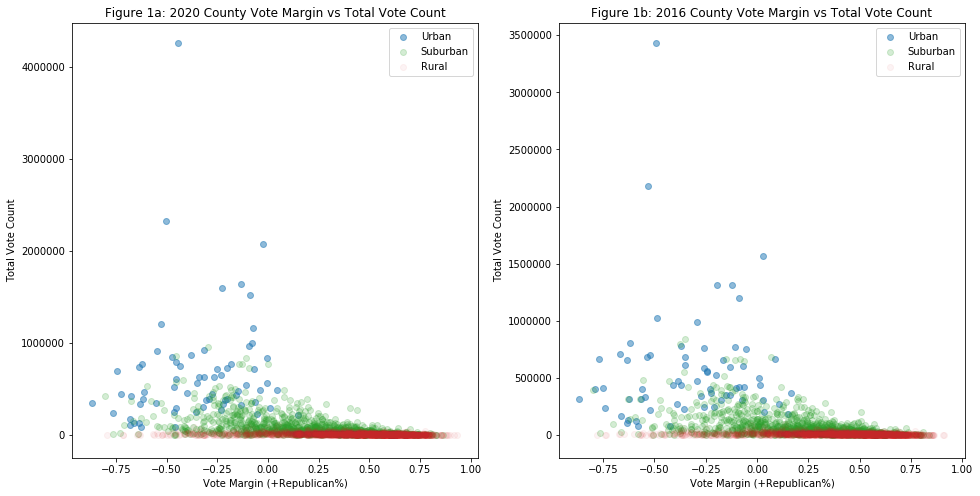

In [221]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.scatter(df[df['usr']==1]['20margin'],df[df['usr']==1]['20total'],c='tab:blue',alpha=0.5,label='Urban')
ax1.scatter(df[df['usr']==2]['20margin'],df[df['usr']==2]['20total'],c='tab:green',alpha=0.2,label='Suburban')
ax1.scatter(df[df['usr']==3]['20margin'],df[df['usr']==3]['20total'],c='tab:red',alpha=0.05,label='Rural')
ax1.set_title('Figure 1a: 2020 County Vote Margin vs Total Vote Count')
ax1.set(xlabel='Vote Margin (+Republican%)',ylabel='Total Vote Count')
ax1.legend()
ax2.scatter(df[df['usr']==1]['16margin'],df[df['usr']==1]['16total'],c='tab:blue',alpha=0.5,label='Urban')
ax2.scatter(df[df['usr']==2]['16margin'],df[df['usr']==2]['16total'],c='tab:green',alpha=0.2,label='Suburban')
ax2.scatter(df[df['usr']==3]['16margin'],df[df['usr']==3]['16total'],c='tab:red',alpha=0.05,label='Rural')
ax2.set_title('Figure 1b: 2016 County Vote Margin vs Total Vote Count')
ax2.set(xlabel='Vote Margin (+Republican%)',ylabel='Total Vote Count')
ax2.legend()

In [262]:
dperc = []
rperc = []

rm20 = (1+df[(df['usr']==1)]['20margin'])/2
dm20 = (1-df[(df['usr']==1)]['20margin'])/2
rt20 = df[(df['usr']==1)]['20total']
dt20 = df[(df['usr']==1)]['20total']
t20 = sum(df[(df['usr']==1)]['20total'])

rperc.append(sum(rm20*rt20)/t20)
dperc.append(sum(dm20*dt20)/t20)

rm20 = (1+df[(df['usr']==2)]['20margin'])/2
dm20 = (1-df[(df['usr']==2)]['20margin'])/2
rt20 = df[(df['usr']==2)]['20total']
dt20 = df[(df['usr']==2)]['20total']
t20 = sum(df[(df['usr']==2)]['20total'])

rperc.append(sum(rm20*rt20)/t20)
dperc.append(sum(dm20*dt20)/t20)

rm20 = (1+df[(df['usr']==3)]['20margin'])/2
dm20 = (1-df[(df['usr']==3)]['20margin'])/2
rt20 = df[(df['usr']==3)]['20total']
dt20 = df[(df['usr']==3)]['20total']
t20 = sum(df[(df['usr']==3)]['20total'])

rperc.append(sum(rm20*rt20)/t20)
dperc.append(sum(dm20*dt20)/t20)

rm20 = (1+df[(df['usr']==1)]['16margin'])/2
dm20 = (1-df[(df['usr']==1)]['16margin'])/2
rt20 = df[(df['usr']==1)]['16total']
dt20 = df[(df['usr']==1)]['16total']
t20 = sum(df[(df['usr']==1)]['16total'])

rperc.append(sum(rm20*rt20)/t20)
dperc.append(sum(dm20*dt20)/t20)

rm20 = (1+df[(df['usr']==2)]['16margin'])/2
dm20 = (1-df[(df['usr']==2)]['16margin'])/2
rt20 = df[(df['usr']==2)]['16total']
dt20 = df[(df['usr']==2)]['16total']
t20 = sum(df[(df['usr']==2)]['16total'])

rperc.append(sum(rm20*rt20)/t20)
dperc.append(sum(dm20*dt20)/t20)
rm20 = (1+df[(df['usr']==3)]['16margin'])/2
dm20 = (1-df[(df['usr']==3)]['16margin'])/2
rt20 = df[(df['usr']==3)]['16total']
dt20 = df[(df['usr']==3)]['16total']
t20 = sum(df[(df['usr']==3)]['16total'])

rperc.append(sum(rm20*rt20)/t20)
dperc.append(sum(dm20*dt20)/t20)




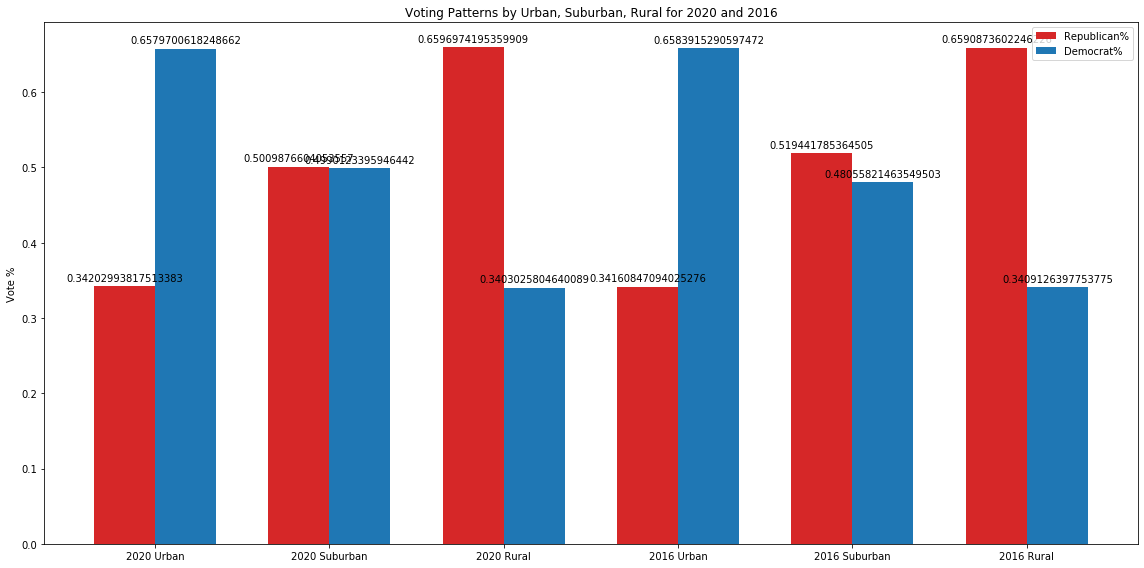

In [266]:
labels = ['2020 Urban', '2020 Suburban', '2020 Rural', '2016 Urban', '2016 Suburban', '2016 Rural']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1,1,figsize=(16,8))
rects1 = ax.bar(x - width/2, rperc, width, label='Republican%',color='tab:red')
rects2 = ax.bar(x + width/2, dperc, width, label='Democrat%',color='tab:blue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Vote %')
ax.set_title('Voting Patterns by Urban, Suburban, Rural for 2020 and 2016')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

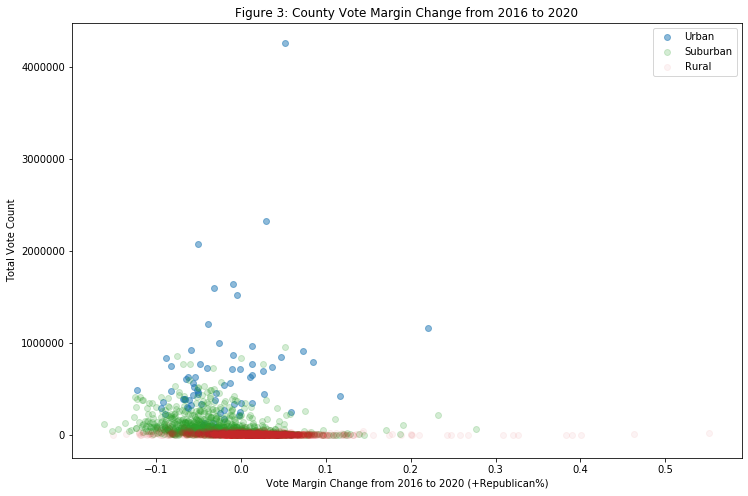

In [224]:
fig, (ax1) = plt.subplots(1,1,figsize=(12,8))
ax1.scatter(df[df['usr']==1]['marginchange'],df[df['usr']==1]['20total'],c='tab:blue',alpha=0.5,label='Urban')
ax1.scatter(df[df['usr']==2]['marginchange'],df[df['usr']==2]['20total'],c='tab:green',alpha=0.2,label='Suburban')
ax1.scatter(df[df['usr']==3]['marginchange'],df[df['usr']==3]['20total'],c='tab:red',alpha=0.05,label='Rural')
ax1.set_title('Figure 3: County Vote Margin Change from 2016 to 2020')
ax1.set(xlabel='Vote Margin Change from 2016 to 2020 (+Republican%)',ylabel='Total Vote Count')
ax1.legend()

In [179]:
import statsmodels.api as sm

X = df[df['usr']==2]['20margin']
y = df[df['usr']==2]['20total']
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

C:\Users\Alan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                20total   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     346.4
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           2.30e-67
Time:                        21:43:09   Log-Likelihood:                -14134.
No. Observations:                1094   AIC:                         2.827e+04
Df Residuals:                    1092   BIC:                         2.828e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.206e+05   3612.685     33.378      0.000    1.13e+05    1.28e+05
20margin   -1.833e+05   9850.417    -18.611      0.000   -2.03e+05   -1.64e+05
==============================================================================
Omnibus:                      711.020   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10631.605
Skew:                           2.776   Prob(JB):                         0.00
Kurtosis:                      17.227   Cond. No.                         3.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

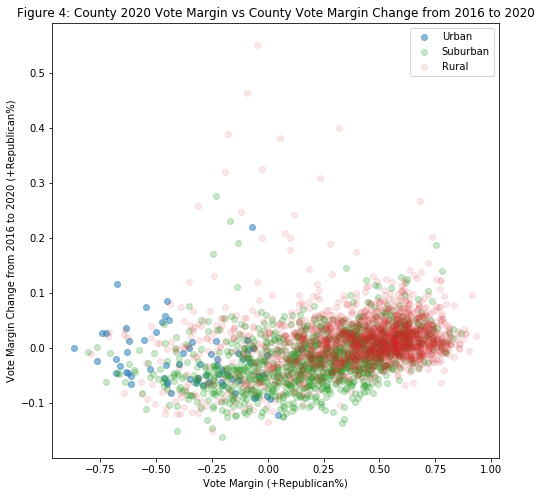

In [225]:
fig, (ax1) = plt.subplots(1,1,figsize=(8,8))
ax1.scatter(df[df['usr']==1]['20margin'],df[df['usr']==1]['marginchange'],c='tab:blue',alpha=0.5,label='Urban')
ax1.scatter(df[df['usr']==2]['20margin'],df[df['usr']==2]['marginchange'],c='tab:green',alpha=0.25,label='Suburban')
ax1.scatter(df[df['usr']==3]['20margin'],df[df['usr']==3]['marginchange'],c='tab:red',alpha=0.1,label='Rural')
ax1.set_title('Figure 4: County 2020 Vote Margin vs County Vote Margin Change from 2016 to 2020')
ax1.set(xlabel='Vote Margin (+Republican%)',ylabel='Vote Margin Change from 2016 to 2020 (+Republican%)')
ax1.legend()

In [185]:
df[df['usr']<3].sort_values(by=['marginchange'])[:10]

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange,2013 code_x,2013 code_y,2013 code,usr
432,13151,0,0,0,GA,Henry County,1,122984,-0.2047,99367,-0.043606,23617,-0.161094,2,2,2,2
479,13247,0,0,0,GA,Rockdale County,1,44676,-0.4078,38087,-0.256702,6589,-0.151098,2,2,2,2
405,13097,0,0,0,GA,Douglas County,1,69112,-0.2512,58123,-0.106464,10989,-0.144736,2,2,2,2
415,13117,0,1,0,GA,Forsyth County,1,129307,0.3319,98964,0.468746,30343,-0.136846,2,2,2,2
222,08014,1,1,1,CO,Broomfield County,1,46637,-0.2741,37690,-0.142319,8947,-0.131781,2,2,2,2
2620,48257,0,0,0,TX,Kaufman County,1,56714,0.3389,41265,0.467927,15449,-0.129027,2,2,2,2
695,18057,1,0,0,IN,Hamilton County,1,194016,0.0680,155966,0.193254,38050,-0.125254,2,2,2,2
424,13135,1,1,1,GA,Gwinnett County,1,414033,-0.1826,330950,-0.057906,83083,-0.124694,2,2,2,2
413,13113,0,0,0,GA,Fayette County,1,71995,0.0680,61511,0.191250,10484,-0.123250,2,2,2,2
1164,24003,1,1,0,MD,Anne Arundel County,1,309644,-0.1454,270081,-0.022275,39563,-0.123125,2,2,2,2


In [187]:
df[df['usr']<3].sort_values(by=['marginchange'])[-10:]

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange,2013 code_x,2013 code_y,2013 code,usr
2747,49003,0,0,0,UT,Box Elder County,2,27321,0.6250,19878,0.500453,7443,0.124547,3,3,3,2
137,05111,0,0,0,AR,Poinsett County,3,7521,0.5976,7722,0.469049,-201,0.128551,4,4,4,2
541,16041,0,0,0,ID,Franklin County,3,6664,0.7785,5499,0.639389,1165,0.139111,4,4,4,2
2606,48229,0,0,0,TX,Hudspeth County,2,1165,0.3502,871,0.205511,294,0.144689,3,3,3,2
169,06025,0,1,0,CA,Imperial County,3,56742,-0.2437,48091,-0.415109,8651,0.171409,4,4,4,2
2757,49023,0,0,0,UT,Juab County,2,5903,0.7525,4221,0.565032,1682,0.187468,3,3,3,2
2522,48061,0,0,1,TX,Cameron County,2,114187,-0.1317,92665,-0.322991,21522,0.191291,3,3,3,2
333,12086,1,1,1,FL,Miami-Dade County,1,1158836,-0.0733,987191,-0.293912,171645,0.220612,1,1,1,1
2599,48215,0,1,0,TX,Hidalgo County,2,220905,-0.1706,174408,-0.402315,46497,0.231715,3,3,3,2
2731,48479,0,0,0,TX,Webb County,2,68405,-0.2328,57585,-0.509855,10820,0.277055,3,3,3,2


In [189]:
df.sort_values(by=['marginchange'])[-20:]

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange,2013 code_x,2013 code_y,2013 code,usr
2522,48061,0,0,1,TX,Cameron County,2,114187,-0.1317,92665,-0.322991,21522,0.191291,3,3,3,2
2546,48109,0,0,0,TX,Culberson County,9,864,-0.0266,767,-0.226858,97,0.200258,6,6,6,3
2616,48249,0,0,0,TX,Jim Wells County,4,13670,0.0975,12379,-0.102916,1291,0.200416,5,5,5,3
2722,48461,0,0,0,TX,Upton County,8,1368,0.7368,1347,0.535264,21,0.201536,6,6,6,3
2573,48163,0,0,0,TX,Frio County,6,5279,0.0760,4400,-0.133636,879,0.209636,6,6,6,3
333,12086,1,1,1,FL,Miami-Dade County,1,1158836,-0.0733,987191,-0.293912,171645,0.220612,1,1,1,1
2599,48215,0,1,0,TX,Hidalgo County,2,220905,-0.1706,174408,-0.402315,46497,0.231715,3,3,3,2
2633,48283,0,0,0,TX,La Salle County,6,2406,0.1177,2059,-0.124818,347,0.242518,6,6,6,3
2736,48489,0,0,0,TX,Willacy County,6,5549,-0.1202,5095,-0.368008,454,0.247808,5,5,5,3
2745,48507,0,0,0,TX,Zavala County,7,4378,-0.3137,3396,-0.571849,982,0.258149,6,6,6,3


In [60]:
df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0)].sort_values(by=['marginchange'])

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange
1164,24003,1,1,0,MD,Anne Arundel County,1,309644,-0.1454,270081,-0.022275,39563,-0.123125
2552,48121,1,1,0,TX,Denton County,1,417960,0.0808,298645,0.199946,119315,-0.119146
245,08059,1,1,0,CO,Jefferson County,1,377363,-0.1855,328883,-0.068714,48480,-0.116786
2186,41017,1,1,0,OR,Deschutes County,3,125244,-0.0824,98557,0.032956,26687,-0.115356
250,08069,1,1,0,CO,Larimer County,2,224348,-0.1544,195981,-0.049408,28367,-0.104992
...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,17031,1,1,0,IL,Cook County,1,2325152,-0.5021,2180344,-0.531411,144808,0.029311
518,15003,1,1,0,HI,Honolulu County,2,382106,-0.2685,285790,-0.298716,96316,0.030216
520,15009,1,1,0,HI,Maui County,3,71053,-0.3545,51945,-0.385677,19108,0.031177
175,06037,1,1,0,CA,Los Angeles County,1,4264818,-0.4417,3434308,-0.493439,830510,0.051739


In [85]:
df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0)].sort_values(by=['20margin'])[-10:]

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange
1756,34025,1,1,0,NJ,Monmouth County,1,378394,0.0278,317750,0.092972,60644,-0.065172
2552,48121,1,1,0,TX,Denton County,1,417960,0.0808,298645,0.199946,119315,-0.119146
348,12115,1,1,0,FL,Sarasota County,2,271194,0.1042,231353,0.114837,39841,-0.010637
48,01097,1,1,0,AL,Mobile County,2,183179,0.1188,172737,0.132745,10442,-0.013945
301,12021,1,1,0,FL,Collier County,2,208286,0.2464,172510,0.257017,35776,-0.010617
2490,47187,1,1,0,TN,Williamson County,1,139018,0.2612,106271,0.350039,32747,-0.088839
1110,22055,1,1,0,LA,Lafayette Parish,2,114528,0.2867,105603,0.335871,8925,-0.049171
80,04025,1,1,0,AZ,Yavapai County,3,143639,0.2919,114450,0.312276,29189,-0.020376
2095,39165,1,1,0,OH,Warren County,1,136437,0.3073,118309,0.371172,18128,-0.063872
2661,48339,1,1,0,TX,Montgomery County,1,271528,0.4383,205904,0.507416,65624,-0.069116


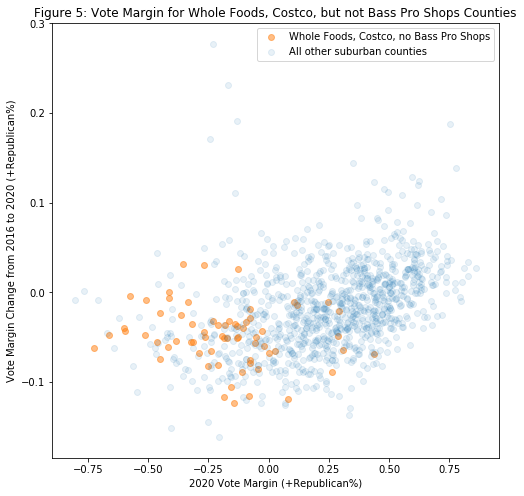

In [234]:
fig, (ax1) = plt.subplots(1,1,figsize=(8,8))
ax1.scatter(df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2)]['20margin'],df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2)]['marginchange'],c='tab:orange',alpha=0.5,label='Whole Foods, Costco, no Bass Pro Shops')
ax1.scatter(df[((df['wf']==0) | (df['cost']==0)) & (df['usr']==2)]['20margin'],df[((df['wf']==0) | (df['cost']==0)) & (df['usr']==2)]['marginchange'],c='tab:blue',alpha=0.1,label='All other suburban counties')
ax1.set_title('Figure 5: Vote Margin for Whole Foods, Costco, but not Bass Pro Shops Counties')
ax1.set(xlabel='2020 Vote Margin (+Republican%)',ylabel='Vote Margin Change from 2016 to 2020 (+Republican%)')
ax1.legend()

In [200]:
len(df[((df['wf']==0) | (df['cost']==0)) & (df['usr']==2) & (df['marginchange']<=0)])/len(df[((df['wf']==0) | (df['cost']==0)) & (df['usr']==2)])

0.6518668012108981

In [203]:
np.sum(np.array(df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2)]['20total']))/np.sum(np.array(df[(df['usr']==2)]['20total']))

0.21693574751373304

In [204]:
np.sum(np.array(df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2) & (df['20margin']<0)]['20total']))/np.sum(np.array(df[(df['usr']==2) & (df['20margin']<0)]['20total']))

0.3552190235224748

In [199]:
df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2)]

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange,2013 code_x,2013 code_y,2013 code,usr
48,01097,1,1,0,AL,Mobile County,2,183179,0.1188,172737,0.132745,10442,-0.013945,3,3,3,2
50,01101,1,1,0,AL,Montgomery County,2,99140,-0.3149,95878,-0.259841,3262,-0.055059,3,3,3,2
77,04019,1,1,0,AZ,Pima County,2,522136,-0.1862,421640,-0.135739,100496,-0.050461,3,3,3,2
80,04025,1,1,0,AZ,Yavapai County,3,143639,0.2919,114450,0.312276,29189,-0.020376,4,4,4,2
163,06013,1,1,0,CA,Contra Costa County,1,581281,-0.4533,473014,-0.429863,108267,-0.023437,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,51059,1,1,0,VA,Fairfax County,1,600788,-0.4186,551183,-0.358180,49605,-0.060420,2,2,2,2
2841,51107,1,1,0,VA,Loudoun County,1,224837,-0.2503,183050,-0.168511,41787,-0.081789,2,2,2,2
2887,51540,1,1,0,VA,Charlottesville city,3,24210,-0.7272,22467,-0.665020,1743,-0.062180,4,4,4,2
2927,53011,1,1,0,WA,Clark County,1,275410,-0.0509,208485,-0.001516,66925,-0.049384,2,2,2,2


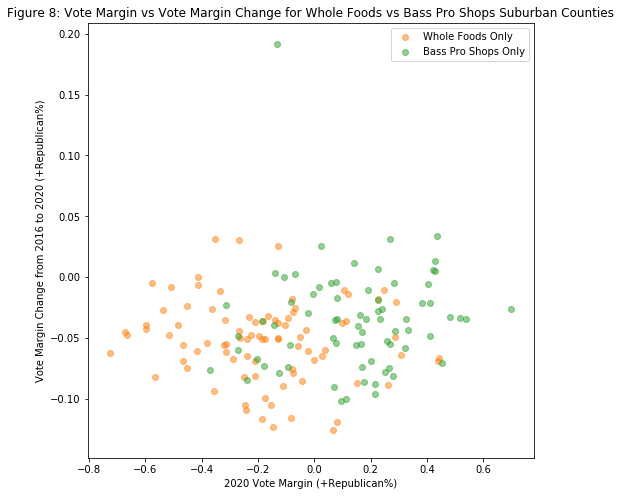

In [235]:
#2020
fig, (ax1) = plt.subplots(1,1,figsize=(8,8))
plt.scatter(df[(df['wf']==1) & (df['bass']==0) & (df['usr']==2)]['20margin'],df[(df['wf']==1) & (df['bass']==0) & (df['usr']==2)]['marginchange'],c='tab:orange',alpha=0.5,label='Whole Foods Only')
plt.scatter(df[(df['wf']==0) & (df['bass']==1) & (df['usr']==2)]['20margin'],df[(df['wf']==0) & (df['bass']==1) & (df['usr']==2)]['marginchange'],c='tab:green',alpha=0.5,label='Bass Pro Shops Only')
ax1.set_title('Figure 8: Vote Margin vs Vote Margin Change for Whole Foods vs Bass Pro Shops Suburban Counties')
ax1.set(xlabel='2020 Vote Margin (+Republican%)',ylabel='Vote Margin Change from 2016 to 2020 (+Republican%)')
ax1.legend()

In [214]:
df[(df['wf']==0) & (df['bass']==1) & (df['usr']==2)].sort_values(by='marginchange')

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange,2013 code_x,2013 code_y,2013 code,usr
1872,37025,0,0,1,NC,Cabarrus County,1,117236,0.0944,93289,0.196143,23947,-0.101743,2,2,2,2
1700,31153,0,1,1,NE,Sarpy County,2,96186,0.1120,80580,0.212336,15606,-0.100336,3,3,3,2
1055,21185,0,1,1,KY,Oldham County,1,37978,0.2145,32853,0.310504,5125,-0.096004,2,2,2,2
2033,39041,0,1,1,OH,Delaware County,1,126368,0.0682,105639,0.158048,20729,-0.089848,2,2,2,2
1270,26139,0,1,1,MI,Ottawa County,2,168723,0.2146,143848,0.302361,24875,-0.087761,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,13207,0,0,1,GA,Monroe County,3,15591,0.4279,12687,0.414676,2904,0.013224,4,4,4,2
2059,39093,0,1,1,OH,Lorain County,1,157778,0.0244,140562,-0.000932,17216,0.025332,2,2,2,2
2751,49011,0,1,1,UT,Davis County,2,173443,0.2694,140288,0.238388,33155,0.031012,3,3,3,2
530,16019,0,0,1,ID,Bonneville County,3,54030,0.4359,44221,0.401823,9809,0.034077,4,4,4,2


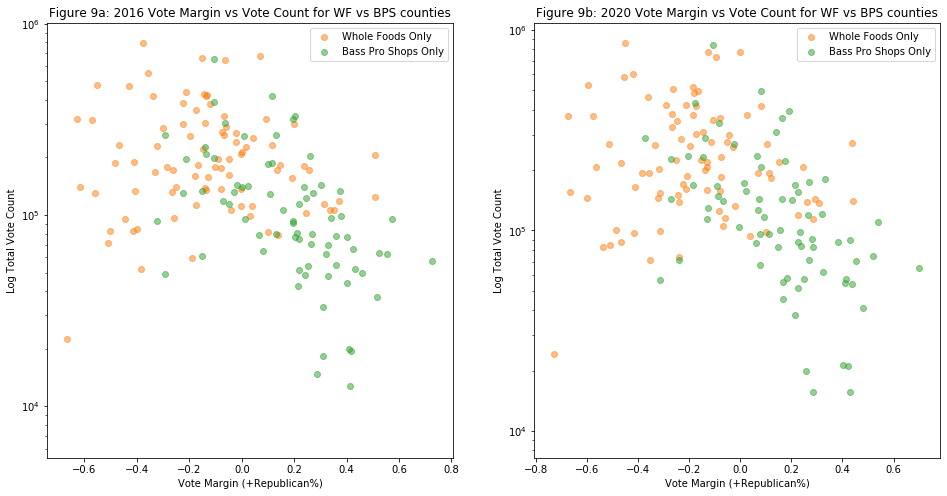

In [236]:
#2016 & 2020 margins vs pop
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))

ax1.scatter(df[(df['wf']==1) & (df['bass']==0) & (df['usr']==2)]['16margin'],df[(df['wf']==1) & (df['bass']==0) & (df['usr']==2)]['16total'],c='tab:orange',alpha=0.5,label='Whole Foods Only')
ax1.scatter(df[(df['wf']==0) & (df['bass']==1) & (df['usr']==2)]['16margin'],df[(df['wf']==0) & (df['bass']==1) & (df['usr']==2)]['16total'],c='tab:green',alpha=0.5,label='Bass Pro Shops Only')
ax1.set_yscale('log')
ax1.set_title('Figure 9a: 2016 Vote Margin vs Vote Count for WF vs BPS counties')
ax1.set(xlabel='Vote Margin (+Republican%)',ylabel='Log Total Vote Count')
ax1.legend()
ax2.scatter(df[(df['wf']==1) & (df['bass']==0) & (df['usr']==2)]['20margin'],df[(df['wf']==1) & (df['bass']==0) & (df['usr']==2)]['20total'],c='tab:orange',alpha=0.5,label='Whole Foods Only')
ax2.scatter(df[(df['wf']==0) & (df['bass']==1) & (df['usr']==2)]['20margin'],df[(df['wf']==0) & (df['bass']==1) & (df['usr']==2)]['20total'],c='tab:green',alpha=0.5,label='Bass Pro Shops Only')
ax2.set_yscale('log')
ax2.set_title('Figure 9b: 2020 Vote Margin vs Vote Count for WF vs BPS counties')
ax2.set(xlabel='Vote Margin (+Republican%)',ylabel='Log Total Vote Count')
ax2.legend()

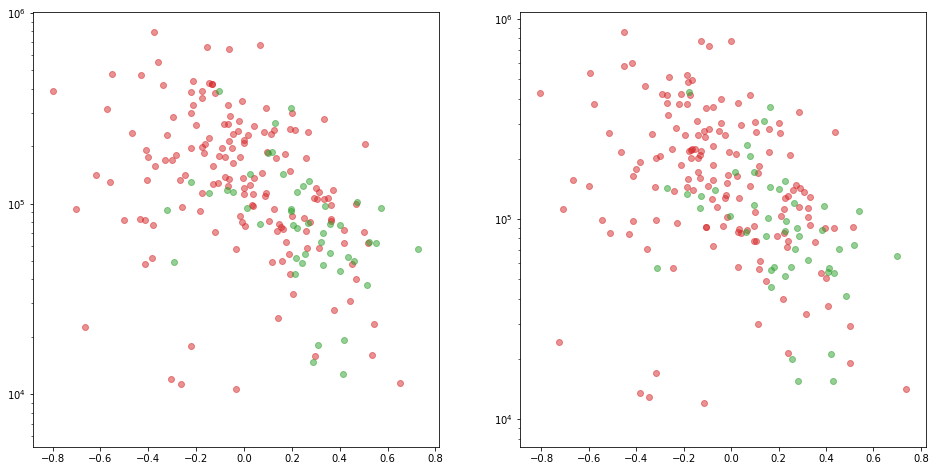

In [158]:
#2016 & 2020 margins vs pop
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))

ax1.scatter(df[(df['cost']==1) & (df['bass']==0) & (df['2013 code']!=1) & (df['RUCC_2013']<=3)]['16margin'],df[(df['cost']==1) & (df['bass']==0) & (df['2013 code']!=1) & (df['RUCC_2013']<=3)]['16total'],c='tab:red',alpha=0.5)
ax1.scatter(df[(df['cost']==0) & (df['bass']==1) & (df['2013 code']!=1) & (df['RUCC_2013']<=3)]['16margin'],df[(df['cost']==0) & (df['bass']==1) & (df['2013 code']!=1) & (df['RUCC_2013']<=3)]['16total'],c='tab:green',alpha=0.5)
ax1.set_yscale('log')

ax2.scatter(df[(df['cost']==1) & (df['bass']==0) & (df['2013 code']!=1) & (df['RUCC_2013']<=3)]['20margin'],df[(df['cost']==1) & (df['bass']==0) & (df['2013 code']!=1) & (df['RUCC_2013']<=3)]['20total'],c='tab:red',alpha=0.5)
ax2.scatter(df[(df['cost']==0) & (df['bass']==1) & (df['2013 code']!=1) & (df['RUCC_2013']<=3)]['20margin'],df[(df['cost']==0) & (df['bass']==1) & (df['2013 code']!=1) & (df['RUCC_2013']<=3)]['20total'],c='tab:green',alpha=0.5)
ax2.set_yscale('log')

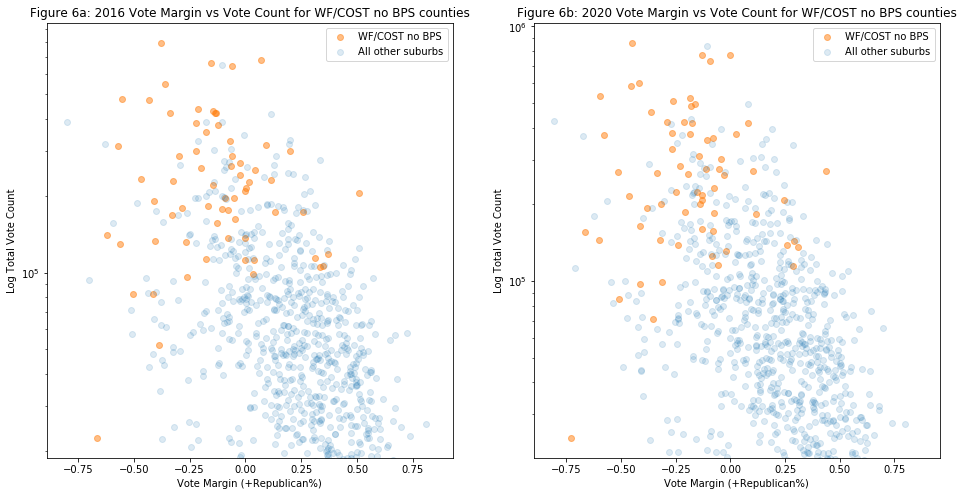

In [233]:
#2016 & 2020 margins vs pop
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))

ax1.scatter(df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2)]['16margin'],df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2)]['16total'],c='tab:orange',alpha=0.5,label='WF/COST no BPS')
ax1.scatter(df[((df['wf']==0) | (df['cost']==0)) & (df['usr']==2)]['16margin'],df[((df['wf']==0) | (df['cost']==0)) & (df['usr']==2)]['16total'],c='tab:blue',alpha=0.15,label='All other suburbs')
ax1.set_yscale('log')
ax1.set_title('Figure 6a: 2016 Vote Margin vs Vote Count for WF/COST no BPS counties')
ax1.set(xlabel='Vote Margin (+Republican%)',ylabel='Log Total Vote Count')
ax1.legend()
ax2.scatter(df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2)]['20margin'],df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2)]['20total'],c='tab:orange',alpha=0.5,label='WF/COST no BPS')
ax2.scatter(df[((df['wf']==0) | (df['cost']==0)) & (df['usr']==2)]['20margin'],df[((df['wf']==0) | (df['cost']==0)) & (df['usr']==2)]['20total'],c='tab:blue',alpha=0.15,label='All other suburbs')
ax2.set_yscale('log')
ax2.set_title('Figure 6b: 2020 Vote Margin vs Vote Count for WF/COST no BPS counties')
ax2.set(xlabel='Vote Margin (+Republican%)',ylabel='Log Total Vote Count')
ax2.legend()

In [163]:
wfcost = df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['2013 code']!=1) & (df['RUCC_2013']<=3)]['20margin']
wfcostd = df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['2013 code']!=1) & (df['RUCC_2013']<=3) & (df['20margin']<=0)]['20margin']
print(len(wfcostd)/len(wfcost))
print(np.mean(np.array(wfcost)))

0.8333333333333334
-0.18502272727272728


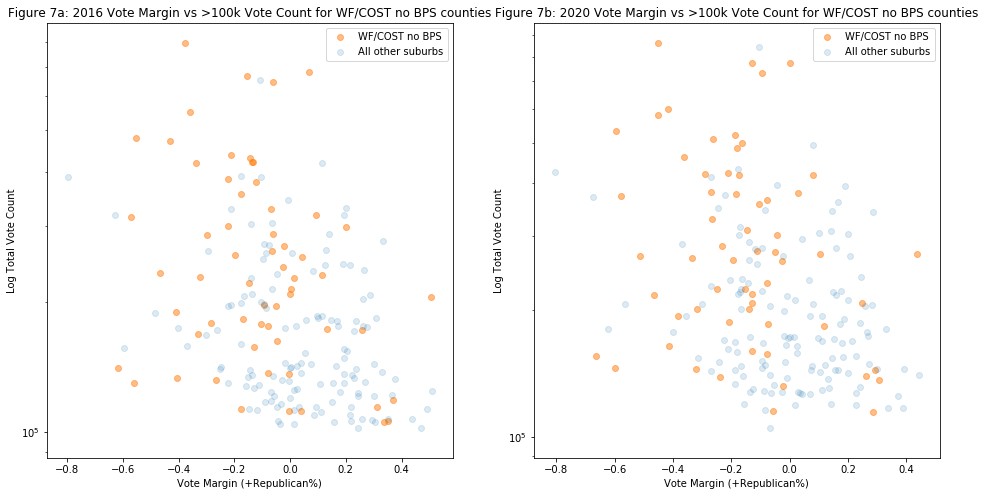

In [232]:
#2016 & 2020 margins vs pop
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))

ax1.scatter(df[(df['16total']>=100000) &(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2)]['16margin'],df[(df['16total']>=100000) &(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2)]['16total'],c='tab:orange',alpha=0.5,label='WF/COST no BPS')
ax1.scatter(df[(df['16total']>=100000) &((df['wf']==0) | (df['cost']==0)) & (df['usr']==2)]['16margin'],df[(df['16total']>=100000) &((df['wf']==0) | (df['cost']==0)) & (df['usr']==2)]['16total'],c='tab:blue',alpha=0.15,label='All other suburbs')
ax1.set_yscale('log')
ax1.set_title('Figure 7a: 2016 Vote Margin vs >100k Vote Count for WF/COST no BPS counties')
ax1.set(xlabel='Vote Margin (+Republican%)',ylabel='Log Total Vote Count')
ax1.legend()
ax2.scatter(df[(df['16total']>=100000) &(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2)]['20margin'],df[(df['16total']>=100000) &(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2)]['20total'],c='tab:orange',alpha=0.5,label='WF/COST no BPS')
ax2.scatter(df[(df['16total']>=100000) &((df['wf']==0) | (df['cost']==0)) & (df['usr']==2)]['20margin'],df[(df['16total']>=100000) &((df['wf']==0) | (df['cost']==0)) & (df['usr']==2)]['20total'],c='tab:blue',alpha=0.15,label='All other suburbs')
ax2.set_yscale('log')
ax2.set_title('Figure 7b: 2020 Vote Margin vs >100k Vote Count for WF/COST no BPS counties')
ax2.set(xlabel='Vote Margin (+Republican%)',ylabel='Log Total Vote Count')
ax2.legend()

In [207]:
len(df[(df['16total']>=100000) &(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2) & (df['20margin']<0)])/len(df[(df['16total']>=100000) &((df['wf']==0) | (df['cost']==0)) & (df['usr']==2) & (df['20margin']<0)])

0.7424242424242424

In [210]:
len(df[(df['16total']>=100000) &(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2) & (df['20margin']<0)])/len(df[(df['16total']>=100000) &(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['usr']==2)])

0.8166666666666667

In [209]:
len(df[(df['16total']>=100000) &((df['wf']==0) | (df['cost']==0)) & (df['usr']==2) & (df['20margin']<0)])/len(df[(df['16total']>=100000) &((df['wf']==0) | (df['cost']==0)) & (df['usr']==2)])

0.49624060150375937

In [160]:
df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['2013 code']!=1) & (df['RUCC_2013']<=3)].sort_values(by='20total')

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange,2013 code
2887,51540,1,1,0,VA,Charlottesville city,3,24210,-0.7272,22467,-0.665020,1743,-0.062180,4
520,15009,1,1,0,HI,Maui County,3,71053,-0.3545,51945,-0.385677,19108,0.031177,4
1927,37135,1,1,0,NC,Orange County,2,84987,-0.5108,82340,-0.502380,2647,-0.008420,3
213,06113,1,1,0,CA,Yolo County,1,97298,-0.4143,82090,-0.414338,15208,0.000038,2
50,01101,1,1,0,AL,Montgomery County,2,99140,-0.3149,95878,-0.259841,3262,-0.055059,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,51059,1,1,0,VA,Fairfax County,1,600788,-0.4186,551183,-0.358180,49605,-0.060420,2
1827,36059,1,1,0,NY,Nassau County,1,732711,-0.0952,647122,-0.062011,85589,-0.033189,2
1849,36103,1,1,0,NY,Suffolk County,1,771767,0.0003,681254,0.068431,90513,-0.068131,2
340,12099,1,1,0,FL,Palm Beach County,1,774615,-0.1276,666212,-0.153511,108403,0.025911,2


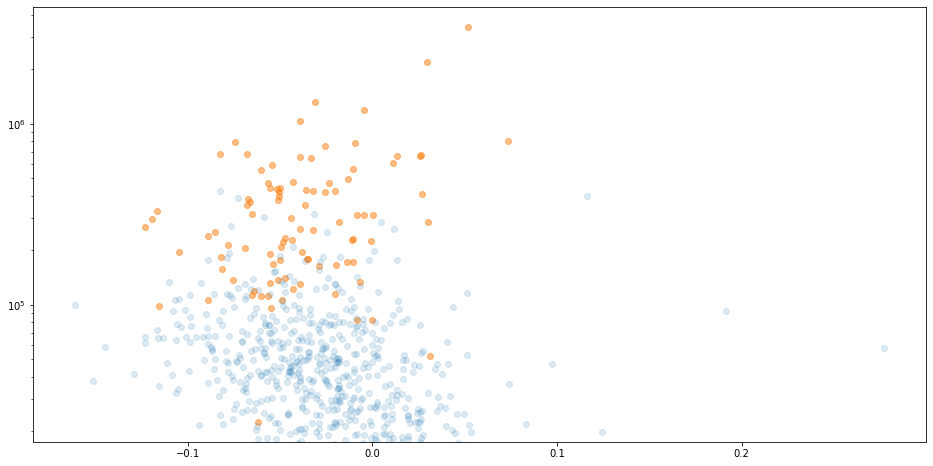

In [143]:
#2016 & 2020 margins vs pop
fig, (ax1) = plt.subplots(1,1,figsize=(16,8))

ax1.scatter(df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['RUCC_2013']<=3)]['marginchange'],df[(df['wf']==1) & (df['cost']==1) & (df['bass']==0) & (df['RUCC_2013']<=3)]['16total'],c='tab:orange',alpha=0.5)
ax1.scatter(df[(df['wf']==0) & (df['cost']==0) & (df['RUCC_2013']<=3)]['marginchange'],df[(df['wf']==0) & (df['cost']==0) & (df['RUCC_2013']<=3)]['16total'],c='tab:blue',alpha=0.15)
ax1.set_yscale('log')

In [99]:
df[(df['wf']==1) & (df['bass']==0)].sort_values(by=['20margin'])

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange
290,11001,1,1,0,DC,District of Columbia,1,344185,-0.8675,311268,-0.867763,32917,0.000263
1186,24510,1,0,0,MD,Baltimore city,1,237362,-0.7659,239402,-0.741297,-2040,-0.024603
1828,36061,1,1,0,NY,New York County,1,697666,-0.7421,668940,-0.768504,28726,0.026404
2887,51540,1,1,0,VA,Charlottesville city,3,24210,-0.7272,22467,-0.665020,1743,-0.062180
194,06075,1,1,0,CA,San Francisco County,1,443530,-0.7254,408541,-0.752424,34989,0.027024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,39165,1,1,0,OH,Warren County,1,136437,0.3073,118309,0.371172,18128,-0.063872
2661,48339,1,1,0,TX,Montgomery County,1,271528,0.4383,205904,0.507416,65624,-0.069116
1134,22103,1,0,0,LA,St. Tammany Parish,1,140118,0.4419,124392,0.508055,15726,-0.066155
528,16015,1,0,0,ID,Boise County,2,4822,0.4730,3814,0.497116,1008,-0.024116


In [100]:
df[(df['wf']==0) & (df['bass']==1)].sort_values(by=['marginchange'])

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange
1872,37025,0,0,1,NC,Cabarrus County,1,117236,0.0944,93289,0.196143,23947,-0.101743
1700,31153,0,1,1,NE,Sarpy County,2,96186,0.1120,80580,0.212336,15606,-0.100336
1055,21185,0,1,1,KY,Oldham County,1,37978,0.2145,32853,0.310504,5125,-0.096004
2033,39041,0,1,1,OH,Delaware County,1,126368,0.0682,105639,0.158048,20729,-0.089848
1270,26139,0,1,1,MI,Ottawa County,2,168723,0.2146,143848,0.302361,24875,-0.087761
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,39093,0,1,1,OH,Lorain County,1,157778,0.0244,140562,-0.000932,17216,0.025332
3037,55043,0,0,1,WI,Grant County,6,25610,0.1227,24368,0.094345,1242,0.028355
2751,49011,0,1,1,UT,Davis County,2,173443,0.2694,140288,0.238388,33155,0.031012
530,16019,0,0,1,ID,Bonneville County,3,54030,0.4359,44221,0.401823,9809,0.034077


In [104]:
df[(df['wf']==1) | (df['bass']==1) | (df['cost']==1)].sort_values(by=['marginchange'])[-10:]

,sFIPS,wf,cost,bass,State,County_Name,RUCC_2013,20total,20margin,16total,16margin,totalchange,marginchange
2454,47115,1,0,0,TN,Marion County,2,13255,0.5080,10862,0.447800,2393,0.060200
1821,36047,1,1,0,NY,Kings County,1,915863,-0.5464,805605,-0.620042,110258,0.073642
2562,48141,1,1,1,TX,El Paso County,2,266701,-0.3516,215922,-0.427613,50779,0.076013
1838,36081,0,1,0,NY,Queens County,1,789989,-0.4511,686393,-0.535960,103596,0.084860
546,16051,0,1,0,ID,Jefferson County,3,14181,0.7361,11475,0.650109,2706,0.085991
339,12097,0,1,0,FL,Osceola County,1,172772,-0.1378,141468,-0.248516,31304,0.110716
169,06025,0,1,0,CA,Imperial County,3,56742,-0.2437,48091,-0.415109,8651,0.171409
2522,48061,0,0,1,TX,Cameron County,2,114187,-0.1317,92665,-0.322991,21522,0.191291
333,12086,1,1,1,FL,Miami-Dade County,1,1158836,-0.0733,987191,-0.293912,171645,0.220612
2599,48215,0,1,0,TX,Hidalgo County,2,220905,-0.1706,174408,-0.402315,46497,0.231715


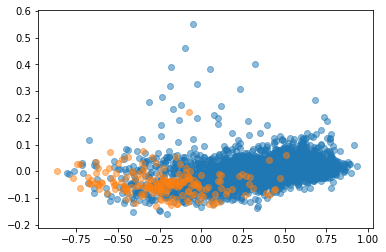

In [64]:
plt.scatter(df[df['wf']==0]['20margin'],df[df['wf']==0]['marginchange'],c='tab:blue',alpha=0.5)
plt.scatter(df[df['wf']==1]['20margin'],df[df['wf']==1]['marginchange'],c='tab:orange',alpha=0.5)

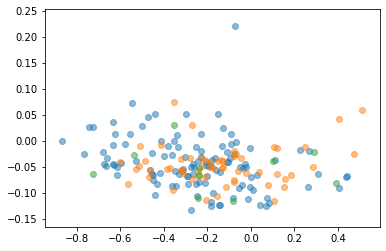

In [48]:
plt.scatter(df[(df['RUCC_2013']==1) & (df['wf']==1)]['20margin'],df[(df['RUCC_2013']==1) & (df['wf']==1)]['marginchange'],c='tab:blue',alpha=0.5)
plt.scatter(df[(df['RUCC_2013']==2) & (df['wf']==1)]['20margin'],df[(df['RUCC_2013']==2) & (df['wf']==1)]['marginchange'],c='tab:orange',alpha=0.5)
plt.scatter(df[(df['RUCC_2013']==3) & (df['wf']==1)]['20margin'],df[(df['RUCC_2013']==3) & (df['wf']==1)]['marginchange'],c='tab:green',alpha=0.5)

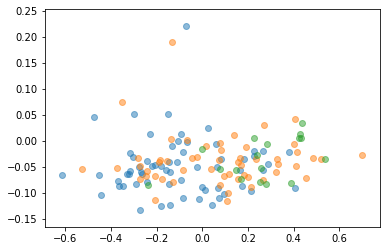

In [49]:
plt.scatter(df[(df['RUCC_2013']==1) & (df['bass']==1)]['20margin'],df[(df['RUCC_2013']==1) & (df['bass']==1)]['marginchange'],c='tab:blue',alpha=0.5)
plt.scatter(df[(df['RUCC_2013']==2) & (df['bass']==1)]['20margin'],df[(df['RUCC_2013']==2) & (df['bass']==1)]['marginchange'],c='tab:orange',alpha=0.5)
plt.scatter(df[(df['RUCC_2013']==3) & (df['bass']==1)]['20margin'],df[(df['RUCC_2013']==3) & (df['bass']==1)]['marginchange'],c='tab:green',alpha=0.5)

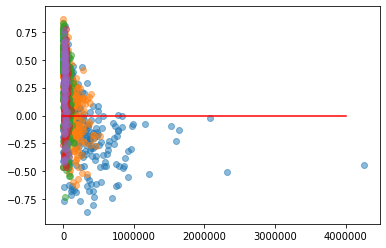

In [29]:
plt.scatter(df20m[df20m['RUCC_2013']==1]['Total Vote'],df20m[df20m['RUCC_2013']==1]['rmargin'],c='tab:blue',alpha=0.5)
plt.scatter(df20m[df20m['RUCC_2013']==2]['Total Vote'],df20m[df20m['RUCC_2013']==2]['rmargin'],c='tab:orange',alpha=0.5)
plt.scatter(df20m[df20m['RUCC_2013']==3]['Total Vote'],df20m[df20m['RUCC_2013']==3]['rmargin'],c='tab:green',alpha=0.5)
plt.scatter(df20m[df20m['RUCC_2013']==4]['Total Vote'],df20m[df20m['RUCC_2013']==4]['rmargin'],c='tab:red',alpha=0.5)
plt.scatter(df20m[df20m['RUCC_2013']==5]['Total Vote'],df20m[df20m['RUCC_2013']==5]['rmargin'],c='tab:purple',alpha=0.5)
plt.plot([0,4000000],[0,0],color='red')

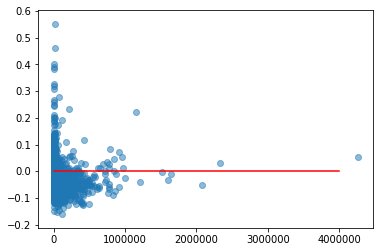

In [31]:
plt.scatter(dfdiff['20total'],dfdiff['marginchange'],alpha=0.5)
plt.plot([0,4000000],[0,0],color='red')

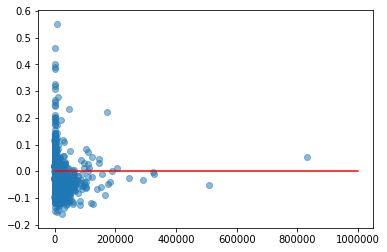

In [34]:
plt.scatter(dfdiff['totalchange'],dfdiff['marginchange'],alpha=0.5)
plt.plot([0,1000000],[0,0],color='red')